# Load data

In [1]:
import time
from functools import partial
from pprint import pprint
from typing import Literal

from audiostream2py.file import WavFileSourceReader #check if Charlie's branch is used
from audiostream2py.data import AudioSegment
from meshed.slabs import Slabs
import numpy as np

from pyckup import grab


In [2]:


plc_url = 'https://www.dropbox.com/s/pwjw0o5ox91nvi2/PLC.wav?dl=0'
wf_url = 'https://www.dropbox.com/s/lxo226rft2h94nf/wf.wav?dl=0'

#wf = graze(wf_url)
plc_bytes = grab(plc_url)
wf_bytes = grab(wf_url)

In [3]:
#plc_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/PLC.wav'
#accel_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/1621346260226336_ch2.wav'

#plc_file = 'data/PLC.wav'
#accel_file = 'data/1621346260226336_ch2.wav'

plc_file = plc_bytes
accel_file = wf_bytes

#assert plc_file.is_file(), f'File not found: {plc_file}'
#assert accel_file.is_file(), f'File not found: {accel_file}'

plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

# print('plc info:')
# pprint(plc_source.info)
# print('accel info:')
# pprint(accel_source.info)

In [60]:
# Charlie's code
class BoolSegmentEdgeDetector:
    last_sample_of_previous_segment = None
    
    def detect_edge_indices(
        self, bool_segment: np.ndarray, edge_type: Literal['rising', 'falling', 'both']
    ) -> list:
        if edge_type not in ['rising', 'falling', 'both']:
            raise ValueError(
                "Valid values for edge_type parameter are 'rising', 'falling', and 'both'."
            )
        if self.last_sample_of_previous_segment is not None:
            bool_segment = np.insert(bool_segment, 0, self.last_sample_of_previous_segment)
        self.last_sample_of_previous_segment = bool_segment[-1]

        int_segment = bool_segment.astype(int)
        edges = np.diff(int_segment)
        if edge_type == 'rising':
            return np.nonzero(edges == 1)[0].tolist()
        elif edge_type == 'falling':
            return np.nonzero(edges == -1)[0].tolist()
        else:
            return np.nonzero(edges)[0].tolist()

def safe_concatenate(seg1, seg2):
    if not seg1:
        return seg2
    elif not seg2:
        return seg1
    else:
        #return np.concatenate((seg1, seg2))
        return seg1 + seg2

def add_segments(segment1: AudioSegment, segment2: AudioSegment) -> AudioSegment: 

    if segment1 is None or segment1.is_empty():
        return segment2
    elif segment2 is None or segment2.is_empty():
        return segment1
    else:
        start = segment1.start_date
        end = segment1.end_date
        #print(f'{segment1.waveform.shape=} {segment2.waveform.shape=}')
        waveform = safe_concatenate(segment1.waveform, segment2.waveform)
        frame_count = segment1.frame_count + segment2.frame_count
        status_flags = segment2.status_flags
        return AudioSegment(start, end, waveform, frame_count, status_flags)

class AudioSegmentBuffer:
    write_state = False
    buffered_segment = AudioSegment.empty()

    def read_values(self, ts):
        if not self.write_state:
            self.write_state = True
            return None
        values = self.buffered_segment[:ts]
        self.buffered_segment = self.buffered_segment[ts:]
        
        return values
    
    def flush(self):
        self.write_state = False
        result = self.buffered_segment
        self.buffered_segment = AudioSegment.empty()
        return result

    def write_values(self, incoming_segment: AudioSegment):
        if self.write_state:
            self.buffered_segment = add_segments(self.buffered_segment, incoming_segment)
            #self.buffered_segment += incoming_segment

In [41]:
void_segment   = AudioSegment.empty()
void_segment.is_empty()
#seg = void_segment.waveform
#np.concatenate((seg, seg))



True

In [28]:
safe_concatenate(seg, seg)

b''

In [46]:
from typing import Union, Tuple, List

def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

def convert_array_to_bool(array: np.ndarray) -> np.ndarray:
    return array != 0  

def instantiate_rising_edge_detector() -> callable:
    return partial(BoolSegmentEdgeDetector().detect_edge_indices,edge_type='rising')

def get_index_of_event(event_detector: callable, data_segment: np.ndarray) -> list[int]: #this is the apply function
    return event_detector(data_segment)

# Should we use generators starting from here? How to separate that concern??

def get_audio_ts_from_index(audio_segment: AudioSegment, index: int) -> tuple:
    return audio_segment.get_ts_of_frame_index(index)

def get_ts_of_index(audio_segment, ind: int) -> Tuple[Union[int, float]]:
        if not 0 <= ind < len(audio_segment.waveform):
            raise IndexError(f'The index must be between 0 and {len(audio_segment.waveform)-1}.')
        bt = audio_segment.bt + ind/len(audio_segment.waveform) * (audio_segment.tt-audio_segment.bt)
        tt = audio_segment.bt + (ind+1)/len(audio_segment.waveform) * (audio_segment.tt-audio_segment.bt)
        return (bt, tt)

def get_bt_of_ts(ts: tuple):
    return ts[0]

def instanciate_audio_segment_buffer():
    return AudioSegmentBuffer()

def write_to_buffer(buffer, audio_segment: AudioSegment) -> None:
    buffer.write_values(audio_segment)

def read_buffer(buffer, ts) -> AudioSegment:
    if ts:
        ts_item = ts[0]
        values = buffer.read_values(ts_item)
        return values
    return None
    #return buffer.read_values(ts)

def convert_bytes_to_floats(bytes_: bytes):
    pass
    # Use recode here
    # wf = np.array(decode_pcm_bytes(wf_bytes)

def first_featurizer(audio_segments: list[AudioSegment]) -> list[float]:
    pass

In [6]:
from creek import BufferStats
from collections import deque
from recode import decode_pcm_bytes


def identity(x):
    return x
bs = BufferStats(values = (-1,-1),maxlen=2, func=identity)

In [7]:
edge_detector = instantiate_rising_edge_detector()
edge_detector(np.array([True, False, True]))

[1]

In [108]:
from meshed.util import if_then_else

# def add_buffer_and_possibly_release(wf_chunk, plc_chunk, buffer):
#     add_to_buffer(wf_chunk, buffer)
#     print(plc_chunk['a'])
#     if plc_chunk['a'] == 4:
#         return release_buffer(buffer)

def clear_deque_and_release():
    result = list(rising_events)
    rising_events.clear()
    return result

cond_func = partial(
    if_then_else,
    if_func=lambda rising_deque: len(list(rising_deque)) >=2,
    #then_func=clear_deque_and_release,
    then_func=lambda : "deque is full",
    else_func=lambda : "deque is not full"
)

def add_to_deque_and_return(d, items):
    d.extend(items)
    return d



In [109]:
# SLABS
counter = 0
with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(.1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)
        next_wf = partial(accel_reader.next, ignore_no_item_found=True)

        audio_buffer = instanciate_audio_segment_buffer()
        edge_detector = instantiate_rising_edge_detector()
        rising_events = deque()

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            wf_segment = next_wf,
            plc_segment = next_plc,
            #last_plc = lambda plc_segment: plc_segment.waveform[-1] ,
            # view_segment = lambda plc_segment: plc_segment.waveform,
            #value_segment = lambda wf_buffer: wf_buffer.waveform,
            int_segment = lambda plc_segment: np.array(decode_pcm_bytes(plc_segment.waveform)),
            bool_segment = lambda int_segment: (int_segment != 0).astype(int),
            #buffered_last = lambda bool_segment: bs(bool_segment[-1]), #(previous_last, current_last),
            edges_charlie = lambda bool_segment: edge_detector(bool_segment),
            #edges = lambda bool_segment, buffered_last: np.diff(bool_segment, prepend=buffered_last[1]),
            #edges_rising_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
            #edges_falling_idx = lambda edges: [i for i, x in enumerate(edges) if x == -1],

            ts_rising = lambda edges_charlie, plc_segment: [('rising',get_ts_of_index(plc_segment, i)) for i in edges_charlie],
            bt_rising = lambda ts_rising: [get_bt_of_ts(ts[1]) for ts in ts_rising],
            rising_deque = lambda bt_rising: add_to_deque_and_return(rising_events, bt_rising),
            read_from_buffer = lambda bt_rising: read_buffer(audio_buffer, bt_rising), #what to do with a list of ts?
            written_to_buffer = lambda wf_segment: write_to_buffer(audio_buffer, wf_segment),
            view_current_buffer = lambda: audio_buffer.buffered_segment,
            release_buffer = lambda rising_deque: "deque is full" if rising_deque and len(list(rising_deque))>=2 else "deque is not full",
            release_deque =cond_func,
            #read_from_buffer = lambda bt_rising: read_buffer(audio_buffer, bt_rising),
            #ts_for_falling_edge = lambda edges_falling_idx, plc_segment: [('falling',get_ts_of_index(plc_segment, i)) for i in edges_falling_idx],
            #begin_ts = lambda plc_segment: get_ts_of_index(plc_segment, 0),
            #end_ts = lambda plc_segment: get_ts_of_index(plc_segment, len(plc_segment.waveform)-1),
            
            #rising_edges_count_mod_2 = lambda edges: sum(x % 2 for x in edges if x==1),
            #bool_plot = lambda bool_segment: simple_plot(bool_segment),

            #sink = lambda last_plc: print(last_plc)
        )

        for s in slabs:
            counter +=1
            #if len(edges_charlie := s.get('edges_charlie')) > 0:
                #print(last_msg)
                #print(f'wf_buffer = {s.get("wf_buffer")} segment={s.get("bool_segment")} edges={s.get("edges")} edges_rising_charlie={s.get("edges_charlie")} bt_rising={s.get("bt_rising")} written={s.get("written_to_buffer")} read={s.get("read_from_buffer")}')

                #print(f'wf_segment = {s.get("wf_segment").waveform[-5:]}')
                #print(f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_ones_idx={s.get("edges_rising_idx")} edges_rising_charlie={s.get("edges_charlie")}')
            #last_msg = f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_rising_charlie={s.get("edges_charlie")}'
            #print(f'edges_rising_charlie={s.get("edges_charlie")} read_from_buffer= {s.get("read_from_buffer")} written_segment = {s.get("written_to_buffer")}')
            print(f'current_buffer={s.get("view_current_buffer")}')
            print(f'release_buffer={s.get("release_buffer")} ')
            print(f'rising_deque={s.get("rising_deque")} ')
            print(f'release_deque={s.get("release_deque")} ')


            if written_to_buffer := s.get('written_to_buffer'):
                print(written_to_buffer)
            if counter>105:
                break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)



TypeError: <lambda>() got an unexpected keyword argument 'kwargs'

In [96]:
rising_events

deque([1140000.0, 4130000.0, 7120000.0, 10110000.0])

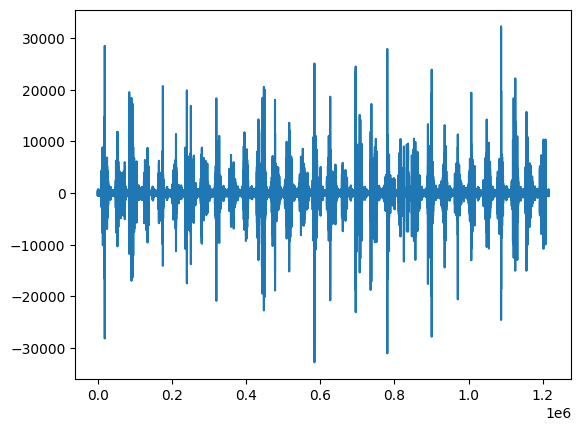

In [77]:
import matplotlib.pyplot as plt
def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

res = convert_bytes_to_array(audio_buffer.buffered_segment.waveform, dtype=np.int16)
plt.plot(res)

In [73]:
accel_reader.next()

AudioSegment(start_date=106000000.0, end_date=107000000.0, frame_count=12800, status_flags=0)

# Simplified slabs

In [ ]:
def to_bool_segment(plc_segment):
    int_segment = np.array(decode_pcm_bytes(plc_segment.waveform))
    bool_segment =  (int_segment != 0).astype(int)
    return bool_segment

In [1]:
# SLABS
counter = 0
with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(.1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            plc_segment = next_plc,
            last_plc = lambda plc_segment: plc_segment.waveform[-1] ,
            #view_segment = lambda plc_segment: plc_segment.waveform,
            int_segment = lambda plc_segment: np.array(decode_pcm_bytes(plc_segment.waveform)),
            bool_segment = lambda int_segment: (int_segment != 0).astype(int),
            buffered_last = lambda bool_segment: bs(bool_segment[-1]), #(previous_last, current_last),

            edges = lambda bool_segment, buffered_last: np.diff(bool_segment, prepend=buffered_last[0]),
            edges_rising_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
            edges_falling_idx = lambda edges: [i for i, x in enumerate(edges) if x == -1],

            ts_for_rising_edge = lambda edges_rising_idx, plc_segment: [('rising',get_ts_of_index(plc_segment, i)) for i in edges_rising_idx],
            ts_for_falling_edge = lambda edges_falling_idx, plc_segment: [('falling',get_ts_of_index(plc_segment, i)) for i in edges_falling_idx],
            begin_ts = lambda plc_segment: get_ts_of_index(plc_segment, 0),
            end_ts = lambda plc_segment: get_ts_of_index(plc_segment, len(plc_segment.waveform)-1),
            
            #rising_edges_count_mod_2 = lambda edges: sum(x % 2 for x in edges if x==1),
            #bool_plot = lambda bool_segment: simple_plot(bool_segment),

            #sink = lambda last_plc: print(last_plc)
        )

        for s in slabs:
            counter +=1
            print(f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_ones_idx={s.get("edges_rising_idx")}')
            if counter>15:
                break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)

NameError: name 'accel_source' is not defined

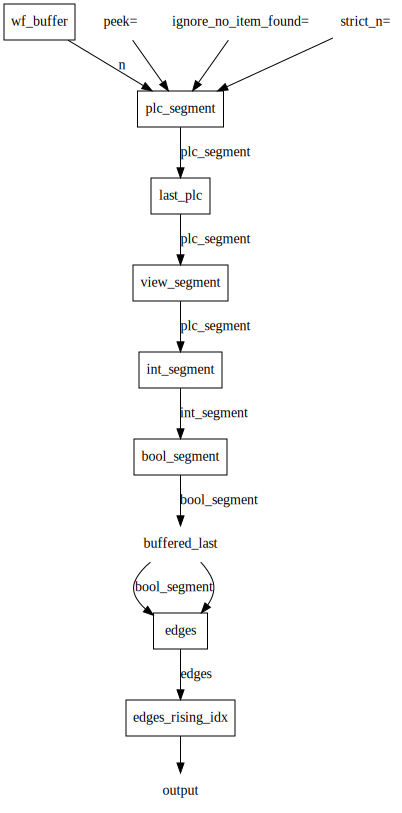

In [19]:
slabs.dot_digraph()

In [ ]:
def intervals_sequence(ts_for_rising_edge, ts_for_falling_edge):
    pass

def add_to_buffer(ts_for_rising_edge, ts_for_falling_edge, begin_ts, end_ts):
    pass

In [ ]:
ts_for_rising_edge = [('rising', (0, 0.0001)), ('rising', (0.0004, 0.0005)), ('rising', (0.0007, 0.0008))]
ts_for_falling_edge = [('falling', (0.0003, 0.0004)), ('falling', (0.0006, 0.0007)), ('falling', (0.0009, 0.0010))]

def order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge):
    ts_for_edge = ts_for_rising_edge + ts_for_falling_edge
    return sorted(ts_for_edge, key=lambda x: x[1][0])

def added_to_buffer(ts_for_rising_edge, ts_for_falling_edge, begin_ts, end_ts, write_state):
    if (not ts_for_rising_edge and not ts_for_falling_edge) and write_state:
        return [(begin_ts, end_ts)]
    ts_for_edge = order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge)
    if ts_for_edge and ts_for_edge[0][0] == 'falling':
        return [(begin_ts, ts_for_edge[0][1][1])]
    return None

def update_buffer(buffer, new_buffer):
    if buffer:
        return buffer + new_buffer
    else:
        return buffer 

def release_buffer(ts_for_edge):
    return ts_for_edge and ts_for_edge[0][0] == 'falling'

def release_buffer():
    pass

order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge)

In [ ]:
BufferStats??

In [ ]:
class accumulate:
    def __init__(self, func, start_value, **kwargs):
        self.func = func
        self.kwargs = kwargs
        self.start_value = start_value
        self.state = start_value

    def __call__(self, x):
        self.state = self.func(self.state, x, **self.kwargs)
        return self.state

In [ ]:
def adder(x,y):
    return x + y

In [ ]:
arr = [1,2,3,4,5]

In [ ]:
acc = accumulate(adder, 0)

In [ ]:
list(map(acc, arr))

# Session with Thor 05/06/2023

1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None


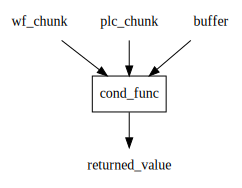

In [22]:
from collections import deque
from itertools import chain, cycle
from slang import fixed_step_chunker
from meshed import code_to_dag

wf_chunks = fixed_step_chunker(range(100), chk_size=5)
plc_chunks = cycle(
    [{'a': 1, 'b': 2}, {'a': 2, 'b': 4}, {'a': 3, 'b': 6}, {'a': 4, 'b': 8}]
)


is_odd = lambda x: (x % 2) == 1


add_to_buffer = lambda wf_chunk, buffer: buffer.append(wf_chunk)

# release the whole buffer
def release_buffer(buffer):
    buffer_contents = list(chain.from_iterable(buffer))
    buffer.clear()
    return buffer_contents


buffer = deque(maxlen=50)

wf_chunk = next(iter(wf_chunks))
plc_chunk = next(iter(plc_chunks))

add_to_buffer([1,2,3], buffer)
add_to_buffer([10,20], buffer) 
assert list(buffer) == [[1, 2, 3], [10, 20]]
release_buffer(buffer) == [1, 2, 3, 10, 20]

def dag_func(wf_chunk, plc_chunk, buffer):
    """if is_odd(plc_chunk['a']) then add wf_chunk to buffer
    and if is_odd(plc_chunk['a']) == 4 then release the buffer"""
    # wf_chunk = next(iter(wf_chunks))
    # plc_chunk = next(iter(plc_chunks))
    if is_odd(plc_chunk['a']):
        add_to_buffer(wf_chunk, buffer)
        if plc_chunk['a'] == 4:
            return release_buffer(buffer)


from functools import partial
from meshed.util import if_then_else

def add_buffer_and_possibly_release(wf_chunk, plc_chunk, buffer):
    add_to_buffer(wf_chunk, buffer)
    print(plc_chunk['a'])
    if plc_chunk['a'] == 4:
        return release_buffer(buffer)


cond_func = partial(
    if_then_else,
    if_func=lambda wf_chunk, plc_chunk, buffer: is_odd(plc_chunk['a']),
    then_func=add_buffer_and_possibly_release,
    else_func=lambda wf_chunk, plc_chunk, buffer: None
)


@code_to_dag
def dag():
    returned_value = cond_func(wf_chunk, plc_chunk, buffer)


dag.dot_digraph()

In [24]:
from slang import fixed_step_chunker
from itertools import cycle
from functools import partial
from meshed.util import if_then_else

wf_chunks = fixed_step_chunker(range(100), chk_size=5)
plc_chunks = cycle(
    [{'a': 1, 'b': 2}, {'a': 2, 'b': 4}, {'a': 3, 'b': 6}, {'a': 4, 'b': 8}]
)

buffer = deque(maxlen=30)


cond_func = partial(
    if_then_else,
    lambda wf_chunk, plc_chunk, buffer: is_odd(plc_chunk['a']),
    add_buffer_and_possibly_release,
    lambda wf_chunk, plc_chunk, buffer: None
)

for wf_chunk, plc_chunk in zip(wf_chunks, plc_chunks):
    # print(plc_chunk)
    print(cond_func(wf_chunk, plc_chunk, buffer))


def return_none_if_any_input_none(func, *args, **kwargs):
    def func_wrapper(*args, **kwargs):
        if any(arg is None for arg in args) or any(kwarg is None for kwarg in kwargs.values()):
            return None
        else:
            return func(*args, **kwargs)
        
    return func_wrapper

1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None


In [143]:
from itertools import cycle

plc_reader = iter([1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1])
next_plc = plc_reader.__next__
audio_sensor_read = cycle([[1, 2, 3], [-96, 87, -92], [320, -96, 99]]).__next__

cond_func = partial(
    if_then_else,
    lambda events: len(list(events)) >= 2,
    lambda x:"deque full",
    lambda x:"deque not full"
)

events_deque = deque(maxlen=10)

def append_and_return(x, events_deque):
    if x==1:
        events_deque.append(x)
    return events_deque

slabs = Slabs(
    plc_segment = next_plc,
    events = lambda plc_segment:append_and_return(plc_segment, events_deque),
    audio_segment = audio_sensor_read,
    deque_full = lambda events:cond_func(events),
)
def consume(slabs, n_int=5):
    for i in range(n_int):
        print(next(slabs))
        



In [144]:
from i2 import Sig
Sig(cond_func)

<Sig (*args, **kwargs)>

In [145]:
consume(slabs,10)

{'plc_segment': 1, 'events': deque([1], maxlen=10), 'audio_segment': [1, 2, 3], 'deque_full': 'deque not full'}
{'plc_segment': 0, 'events': deque([1], maxlen=10), 'audio_segment': [-96, 87, -92], 'deque_full': 'deque not full'}
{'plc_segment': 0, 'events': deque([1], maxlen=10), 'audio_segment': [320, -96, 99], 'deque_full': 'deque not full'}
{'plc_segment': 1, 'events': deque([1, 1], maxlen=10), 'audio_segment': [1, 2, 3], 'deque_full': 'deque full'}
{'plc_segment': 0, 'events': deque([1, 1], maxlen=10), 'audio_segment': [-96, 87, -92], 'deque_full': 'deque full'}
{'plc_segment': 0, 'events': deque([1, 1], maxlen=10), 'audio_segment': [320, -96, 99], 'deque_full': 'deque full'}
{'plc_segment': 0, 'events': deque([1, 1], maxlen=10), 'audio_segment': [1, 2, 3], 'deque_full': 'deque full'}
{'plc_segment': 0, 'events': deque([1, 1], maxlen=10), 'audio_segment': [-96, 87, -92], 'deque_full': 'deque full'}
{'plc_segment': 0, 'events': deque([1, 1], maxlen=10), 'audio_segment': [320, -96, 9

In [128]:
audio_sensor_read = cycle([[1, 2, 3], [-96, 87, -92], [320, -96, 99]])
next(audio_sensor_read)

[1, 2, 3]